In [10]:
import warnings
warnings.filterwarnings('ignore')
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "utils")))
from analysis_utils import (
    volcano_plot_br,
    plot_spatial_clusters_per_sample,
    plot_dotplot_by_treatment,
    plot_relative_cluster_composition,
    score_and_plot_modules, 
    volcano_plot_region_within_group
)
import scanpy as sc
import numpy as np

import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
ad = sc.read_h5ad('../data/ST_BRICHOS.h5ad')


In [3]:
ad.obs['barcode'] = list(pd.DataFrame(ad.obs.index)[0].str.split('-P', expand = True)[0])

In [4]:
import os
import pandas as pd

folder = "../data/anatomical_annotations"
annotated_dfs_L = []
project_names = []
for file in os.listdir(folder):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(folder, file))
        df.columns = [0, 1]  # Rename columns to 0 (barcode), 1 (region)

        # Append sample name to each barcode
        df[0] = df[0].astype(str) + "-" + file.split(' ')[2].split('.')[0]
        df = df.set_index(0)
        annotated_dfs_L.append(df)
    
# Optionally, concatenate all into a single DataFrame
annotated_df = pd.concat(annotated_dfs_L)

In [5]:
mapper = dict(zip(df.index, df[1]))

In [6]:
# Map to region
ad.obs["region_annotation"] = ad.obs.index.map(annotated_df[1])

# Optional: check how many barcodes matched
matched = ad.obs["region_annotation"].notna().sum()
print(f"✅ Mapped region annotation to {matched} spots")

✅ Mapped region annotation to 17613 spots


In [7]:
ad.obs

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,sample,sample_id,n_genes,leiden,treatment,barcode,region_annotation
AAACAAGTATCTCCCA-1-P24215_301,1,50,102,28217,34029,P24215_301,P24215_301,5333,7,BRICHOS,AAACAAGTATCTCCCA-1,NaN
AAACAGAGCGACTCCT-1-P24215_301,1,14,94,10018,31732,P24215_301,P24215_301,3317,2,BRICHOS,AAACAGAGCGACTCCT-1,NaN
AAACCGGGTAGGTACC-1-P24215_301,1,42,28,24142,12539,P24215_301,P24215_301,4982,5,BRICHOS,AAACCGGGTAGGTACC-1,NaN
AAACCGTTCGTCCAGG-1-P24215_301,1,52,42,29202,16598,P24215_301,P24215_301,6046,0,BRICHOS,AAACCGTTCGTCCAGG-1,NaN
AAACCTCATGAAGTTG-1-P24215_301,1,37,19,21611,9928,P24215_301,P24215_301,6179,5,BRICHOS,AAACCTCATGAAGTTG-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTGTGCTAC-1-P28052_203,1,24,64,15524,23040,P28052_203,P28052_203,7233,4,PBS,TTGTTCAGTGTGCTAC-1,Putamen
TTGTTGTGTGTCAAGA-1-P28052_203,1,31,77,19072,26813,P28052_203,P28052_203,7315,4,PBS,TTGTTGTGTGTCAAGA-1,Putamen
TTGTTTCATTAGTCTA-1-P28052_203,1,60,30,33717,13124,P28052_203,P28052_203,6504,2,PBS,TTGTTTCATTAGTCTA-1,Ophtalmic region
TTGTTTCCATACAACT-1-P28052_203,1,45,27,26128,12265,P28052_203,P28052_203,5322,2,PBS,TTGTTTCCATACAACT-1,Ophtalmic region


In [8]:
region_name_mapper = {
    # Unified Cortex Layer names
    "Cortex Layer 1": "Cortex L1",
    "Cortex layer 2/3/4": "Cortex L2/3/4",
    "Cortex Layers 2/3/4": "Cortex L2/3/4",
    "Cortex Layers 2/3": "Cortex L2/3",
    "Cortex Layers 4/5/5": "Cortex L4/5",
    "Cortex Layers 4/5/6": "Cortex L4/5/6",
    "Cortex layers 5/6": "Cortex L5/6",
    "Cortex Layers 5/6": "Cortex L5/6",

    # Optical region variants
    "Optical area": "Optical Region",
    "Optical Region": "Optical Region",
    "Optical region": "Optical Region",
    "Ophtalmic region": "Optical Region",

    # Olfactory variants
    "Olfactory Area": "Olfactory Region",
    "Olfactory region": "Olfactory Region",
    "Olfactory Region": "Olfactory Region",

    # Amygdala
    "Amygdala Region": "Amygdala",
    "Amygdala region": "Amygdala",

    # Septal nucleus
    "Septal nucleus": "Septal Nucleus",

    # Ventricular
    "Ventricular region": "Ventricular Region",

    # Keep original for unique names
    "Striatum": "Striatum",
    "Caudoputamen": "Caudoputamen",
    "Corpus Callosum": "Corpus Callosum",
    "Periventricular area": "Periventricular Area",
    "Septal Nucleus": "Septal Nucleus",
    "Excluded": "Excluded",
    "Hippocampus": "Hippocampus",
    "Hypothalamus": "Hypothalamus",
    "Thalamus": "Thalamus",
    "Putamen": "Putamen",
    None: None,
    float('nan'): None  # For handling np.nan
}
ad.obs["region_annotation"] = ad.obs["region_annotation"].map(region_name_mapper)

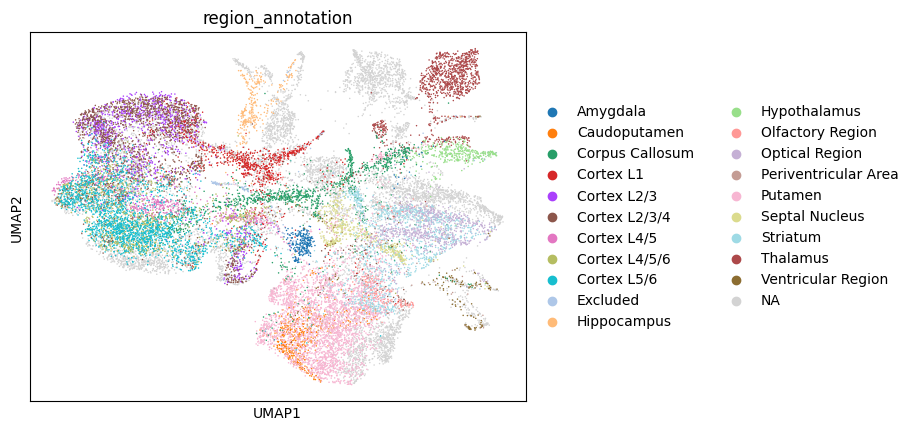

In [12]:
sc.pl.umap(ad, color = 'region_annotation')

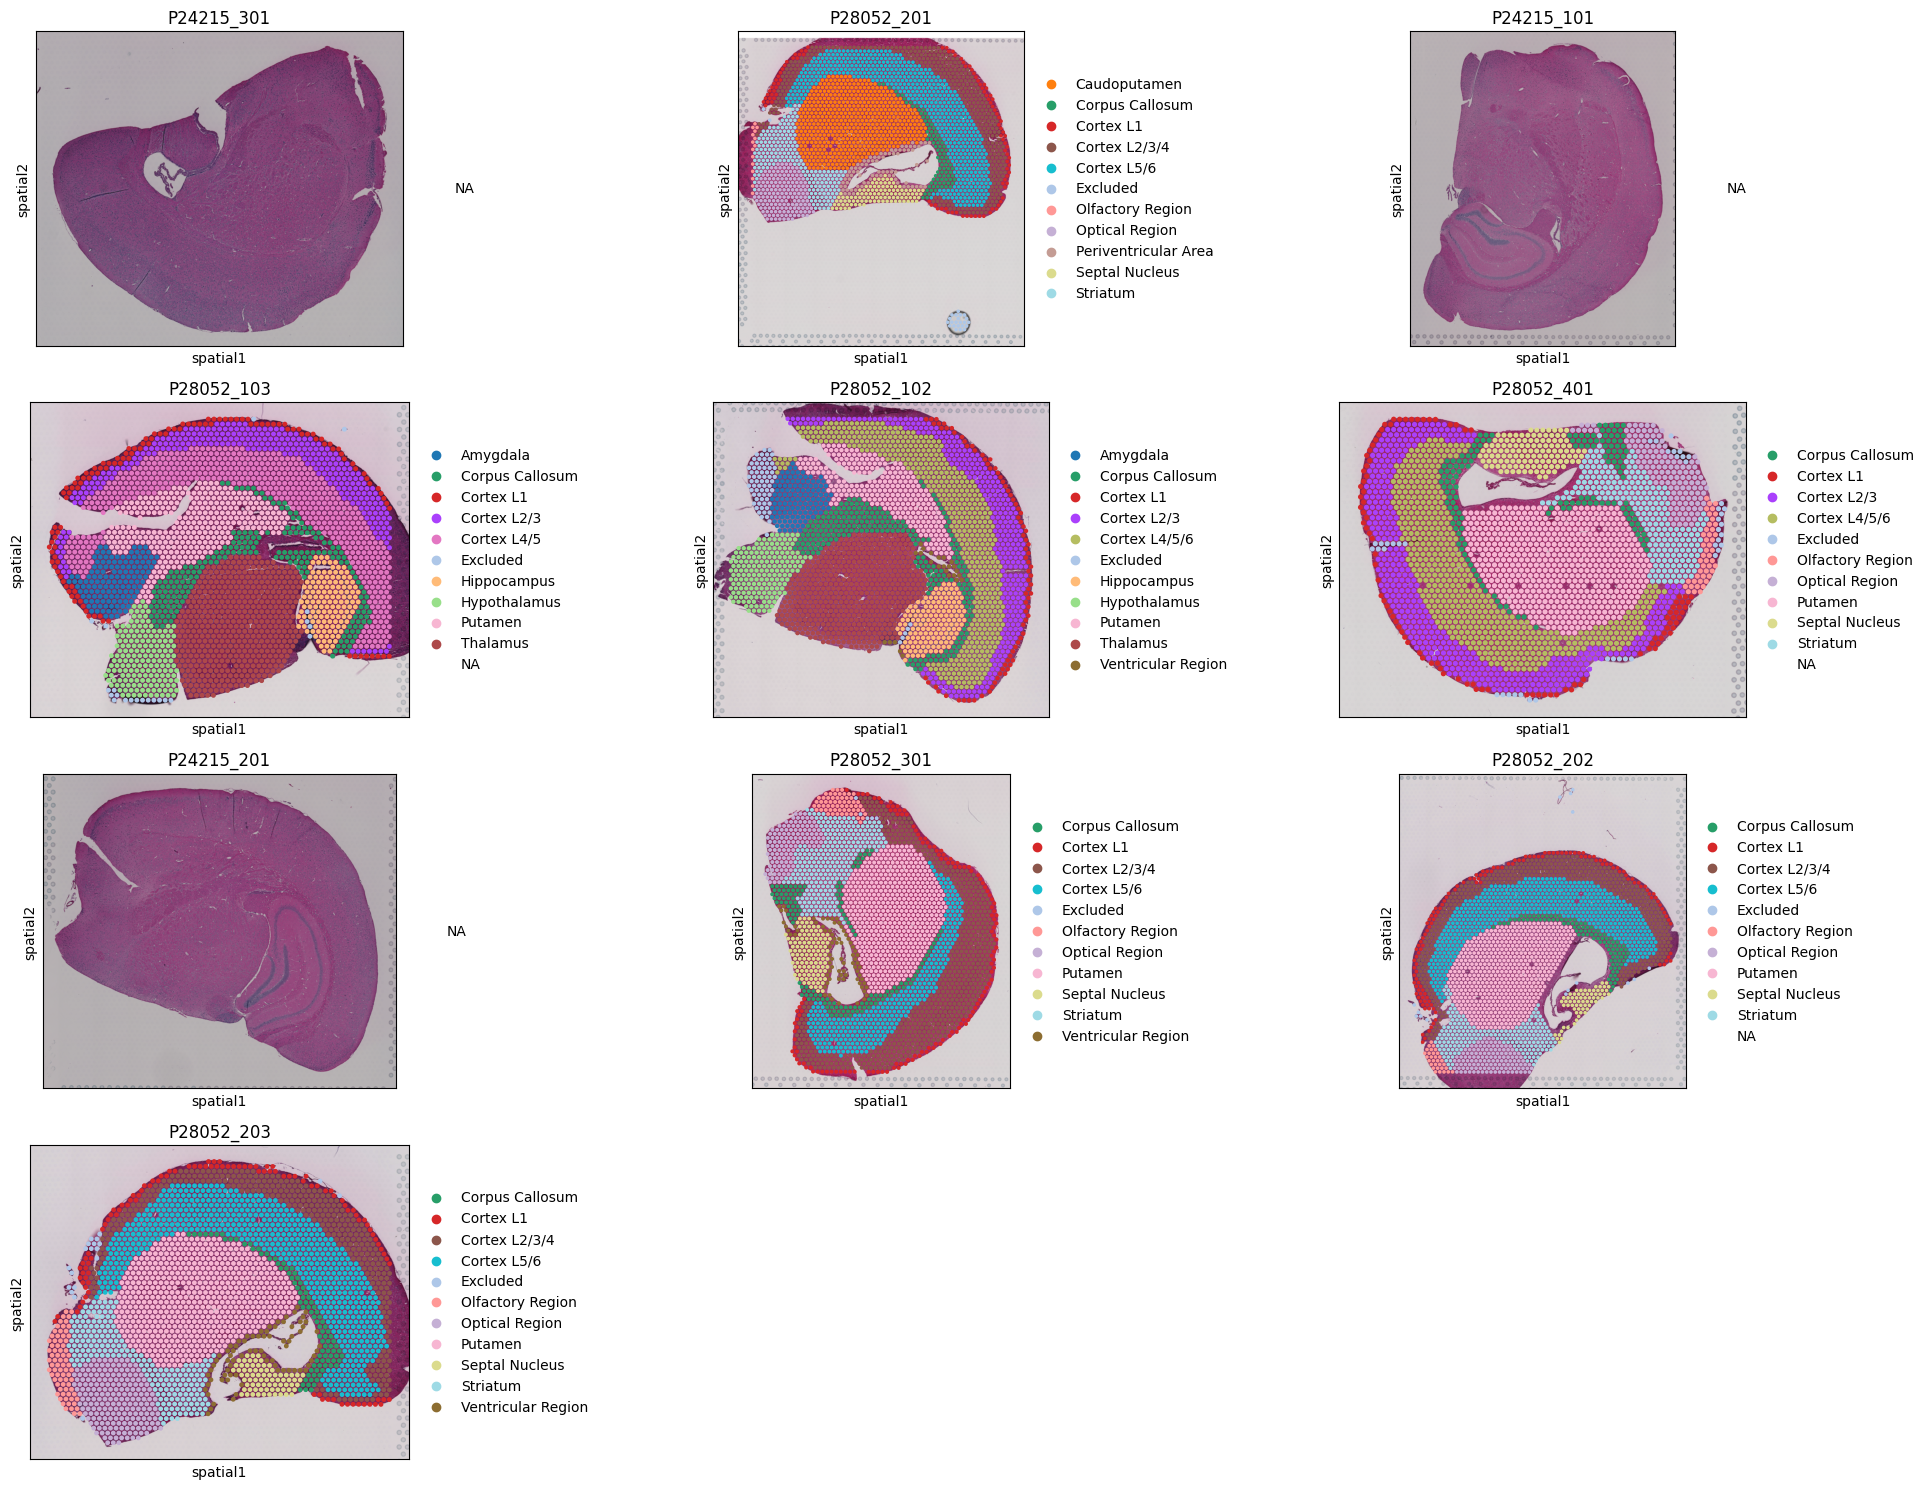

In [13]:
plot_spatial_clusters_per_sample(ad, color = 'region_annotation', figsize=(20,15))

In [14]:
ad.write('../data/ST_BRICHOS_region.h5ad')